In [1]:
import gc
import os
import sys
import warnings
from glob import glob
import matplotlib.pyplot as plt

import albumentations as A
from albumentations.pytorch import ToTensorV2
import pandas as pd
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import segmentation_models_pytorch as smp
from torch.cuda import amp
from tqdm import tqdm

In [2]:
sys.path.append('../')
from script.metrics import *
from script.dataset import *
from script.helper import *
from script.scheduler import *
from script.loss import *

### Config

In [3]:
class CFG:
    debug = False
    # ============== comp exp name =============
    comp_name = 'contrail'
    comp_dir_path = '/kaggle/input/'
    comp_folder_name = 'google-research-identify-contrails-reduce-global-warming'

    dataset_path = "/kaggle/working/dataset_train/ash_color/"

    exp_name = os.getcwd().split('/')[-1]

    # ============== model cfg =============
    model_arch = 'Unet'
    backbone = 'timm-resnest26d'
    in_chans = 3
    target_size = 1

    # ============== training cfg =============
    train_batch_size = 32
    valid_batch_size = train_batch_size

    epochs = 90
    epochs_patience = 12

    lr = 1e-4
    loss = "DiceLoss"

    # ============== fixed =============
    num_workers = 4
    seed = 42

    # ============== augmentation =============
    train_aug_list = [
        A.RandomRotate90(),
        A.RandomBrightnessContrast(),
        A.ShiftScaleRotate(p=0.5,rotate_limit=(10,10)),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=10, max_width=int(256 * 0.05), max_height=int(256 * 0.05),
                        mask_fill_value=0, p=0.5),
        A.RandomGridShuffle(),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        ToTensorV2(transpose_mask=True),
    ]


warnings.filterwarnings("ignore")
torch.backends.cudnn.benchmark = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
set_seed(CFG.seed)
os.makedirs(f'./{CFG.exp_name}/', exist_ok=True)

# Dataset

In [4]:
train_df = pd.read_csv(f"{CFG.dataset_path}/train_df.csv")
valid_df = pd.read_csv(f"{CFG.dataset_path}/validation_df.csv")

if CFG.debug:
    train_df=train_df[:2000]
    valid_df=valid_df[:2000]
train_df.shape, valid_df.shape

((20529, 2), (1856, 2))

In [5]:
dataset_train = ContrailsDataset(train_df, CFG.train_aug_list)
dataset_valid = ContrailsDataset(valid_df, CFG.valid_aug_list)

dataloader_train = DataLoader(dataset_train, batch_size=CFG.train_batch_size , shuffle=True, num_workers = CFG.num_workers)
dataloader_valid = DataLoader(dataset_valid, batch_size=CFG.valid_batch_size, num_workers = CFG.num_workers)

print(f"""
{len(dataset_train) = }
train_image_shape : {dataset_train[0][0].shape}
train_mask_shape  : {dataset_train[0][1].shape}
train_image_dtype : {dataset_train[0][0].dtype}
train_mask_dtype : {dataset_train[0][1].dtype}

{len(dataset_valid) = }
valid_image_shape : {dataset_valid[0][0].shape}
valid_mask_shape  : {dataset_valid[0][1].shape}
valid_image_dtype : {dataset_valid[0][0].dtype}
valid_mask_dtype : {dataset_valid[0][1].dtype}
""")

# show_dataset(112, dataset_train)


len(dataset_train) = 20529
train_image_shape : torch.Size([3, 256, 256])
train_mask_shape  : torch.Size([1, 256, 256])
train_image_dtype : torch.float32
train_mask_dtype : torch.float32

len(dataset_valid) = 1856
valid_image_shape : torch.Size([3, 256, 256])
valid_mask_shape  : torch.Size([1, 256, 256])
valid_image_dtype : torch.float32
valid_mask_dtype : torch.float32



# Model

In [6]:
class CustomModel(nn.Module):
    def __init__(self,model_arch, backbone, in_chans, target_size, weight):
        super().__init__()

        self.model = smp.create_model(
            model_arch,
            encoder_name=backbone,
            encoder_weights=weight,
            in_channels=in_chans,
            classes=target_size,
            activation=None,
        )
        
    def forward(self, image):
        output = self.model(image)
        return output


def build_model(model_arch, backbone, in_chans, target_size, weight="imagenet"):
    print('model_arch: ', model_arch)
    print('backbone: ', backbone)
    model = CustomModel(model_arch, backbone, in_chans, target_size, weight)
    return model


num_gpus = torch.cuda.device_count()
device_ids = list(range(num_gpus))

model = build_model(CFG.model_arch, CFG.backbone, CFG.in_chans, CFG.target_size)
model = nn.DataParallel(model, device_ids=device_ids)
model.to(device);

model_arch:  Unet
backbone:  timm-resnest26d


In [7]:
scaler = amp.GradScaler()
criterion = get_lossfn(CFG)
optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

thresholds_to_test = [round(x * 0.01, 2) for x in range(1, 101, 2)]

# Training

In [8]:
if CFG.debug:
    print("!!!Debug mode!!!\n")

dice_score=0
for epoch in range(CFG.epochs):
    model.train()
    
    pbar_train = enumerate(dataloader_train)
    pbar_train = tqdm(pbar_train, total=len(dataloader_train), bar_format="{l_bar}{bar:10}{r_bar}{bar:-0b}")
    loss_train, loss_val= 0.0, 0.0
    for i, (images, masks) in pbar_train:
        images, masks = cutmix(images, masks)
        images, masks = images.cuda(), masks.cuda()
        optimizer.zero_grad()
        with amp.autocast():
            preds = model(images)
            loss = criterion(preds, masks)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            loss_train += loss.detach().item()
        
        lr = f"LR : {scheduler.get_last_lr()[0]:.2E}"
        gpu_mem = f"Mem : {torch.cuda.memory_reserved() / 1E9:.3g}GB"
        pbar_train.set_description(("%10s  " * 3 + "%10s") % (f"Epoch {epoch}/{CFG.epochs}", gpu_mem, lr,
                                                                f"Loss: {loss_train / (i + 1):.4f}"))

    scheduler.step()
    model.eval()
    
    cum_pred = []
    cum_true = []
    pbar_val = enumerate(dataloader_valid)
    pbar_val = tqdm(pbar_val, total=len(dataloader_valid), bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
    for i, (images, masks) in pbar_val:
        images, masks = images.cuda(), masks.cuda()
        with torch.no_grad():
            preds = model(images)
            loss_val += criterion(preds, masks).item()
            preds = torch.sigmoid(preds)
            cum_pred.append(preds.cpu().detach().numpy())
            cum_true.append(masks.cpu().detach().numpy())

        pbar_val.set_description(("%10s") % (f"Val Loss: {loss_val / (i+1):.4f}"))
    
    cum_pred = torch.flatten(torch.from_numpy(np.concatenate(cum_pred, axis=0)))
    cum_true = torch.flatten(torch.from_numpy(np.concatenate(cum_true, axis=0)))
    
    dice_score_, thresh = calc_optim_thresh(cum_pred, cum_true, thresholds_to_test)
    
    if dice_score_ > dice_score:
        print(f"FBeta : {dice_score_:.4f}\tthresh : {thresh}\tSAVED MODEL\n")
        epoch_best=epoch
        dice_score =dice_score_
        torch.save({'model': model.module.state_dict(), 'dice_score': dice_score, 'thresh': thresh,
                    "model_arch":CFG.model_arch, "backbone":CFG.backbone,"in_chans":CFG.in_chans,"target_size":CFG.target_size,},
                    f'./{CFG.exp_name}/{CFG.exp_name}.pth')
    else:
        print(f"FBeta : {dice_score_:.4f}\tthresh : {thresh}\n")
    
    if epoch-epoch_best>=CFG.epochs_patience:
        print('Early Stopping')
        break
        
!curl -X POST -H 'Authorization: Bearer '$LINE -F 'message=セルの実行が終わりました！{dice_score}' https://notify-api.line.me/api/notify


Epoch 0/90  Mem : 7.79GB  LR : 1.00E-04  Loss: 0.8102: 100%|██████████| 642/642 
Val Loss: 0.6603: 100%|██████████| 58/58 [00:03<00:00, 15.92it/s]               


FBeta : 0.5129	thresh : 0.27	SAVED MODEL



Epoch 1/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.5462: 100%|██████████| 642/642 
Val Loss: 0.6277: 100%|██████████| 58/58 [00:03<00:00, 14.68it/s]               


FBeta : 0.4412	thresh : 0.01



Epoch 2/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.5029: 100%|██████████| 642/642 
Val Loss: 0.5243: 100%|██████████| 58/58 [00:03<00:00, 15.17it/s]               


FBeta : 0.5120	thresh : 0.65



Epoch 3/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4932: 100%|██████████| 642/642 
Val Loss: 0.5073: 100%|██████████| 58/58 [00:03<00:00, 14.91it/s]               


FBeta : 0.5284	thresh : 0.73	SAVED MODEL



Epoch 4/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4809: 100%|██████████| 642/642 
Val Loss: 0.5128: 100%|██████████| 58/58 [00:03<00:00, 15.05it/s]               


FBeta : 0.5256	thresh : 0.45



Epoch 5/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4772: 100%|██████████| 642/642 
Val Loss: 0.4716: 100%|██████████| 58/58 [00:03<00:00, 15.00it/s]               


FBeta : 0.5588	thresh : 0.67	SAVED MODEL



Epoch 6/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4706: 100%|██████████| 642/642 
Val Loss: 0.4728: 100%|██████████| 58/58 [00:03<00:00, 14.56it/s]               


FBeta : 0.5616	thresh : 0.01	SAVED MODEL



Epoch 7/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4693: 100%|██████████| 642/642 
Val Loss: 0.4636: 100%|██████████| 58/58 [00:03<00:00, 15.01it/s]               


FBeta : 0.5696	thresh : 0.17	SAVED MODEL



Epoch 8/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4650: 100%|██████████| 642/642 
Val Loss: 0.4541: 100%|██████████| 58/58 [00:03<00:00, 15.11it/s]               


FBeta : 0.5774	thresh : 0.39	SAVED MODEL



Epoch 9/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4596: 100%|██████████| 642/642 
Val Loss: 0.4690: 100%|██████████| 58/58 [00:03<00:00, 15.00it/s]               


FBeta : 0.5628	thresh : 0.47



Epoch 10/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4587: 100%|██████████| 642/642
Val Loss: 0.4763: 100%|██████████| 58/58 [00:03<00:00, 15.16it/s]               


FBeta : 0.5599	thresh : 0.75



Epoch 11/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4574: 100%|██████████| 642/642
Val Loss: 0.4445: 100%|██████████| 58/58 [00:03<00:00, 15.11it/s]               


FBeta : 0.5848	thresh : 0.03	SAVED MODEL



Epoch 12/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4549: 100%|██████████| 642/642
Val Loss: 0.4784: 100%|██████████| 58/58 [00:03<00:00, 14.95it/s]               


FBeta : 0.5644	thresh : 0.99



Epoch 13/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4504: 100%|██████████| 642/642
Val Loss: 0.4425: 100%|██████████| 58/58 [00:03<00:00, 15.05it/s]               


FBeta : 0.5935	thresh : 0.01	SAVED MODEL



Epoch 14/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4495: 100%|██████████| 642/642
Val Loss: 0.4657: 100%|██████████| 58/58 [00:03<00:00, 14.94it/s]               


FBeta : 0.5656	thresh : 0.99



Epoch 15/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4519: 100%|██████████| 642/642
Val Loss: 0.4402: 100%|██████████| 58/58 [00:03<00:00, 14.97it/s]               


FBeta : 0.5889	thresh : 0.07



Epoch 16/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4457: 100%|██████████| 642/642
Val Loss: 0.4521: 100%|██████████| 58/58 [00:03<00:00, 15.05it/s]               


FBeta : 0.5720	thresh : 0.31



Epoch 17/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4479: 100%|██████████| 642/642
Val Loss: 0.4457: 100%|██████████| 58/58 [00:03<00:00, 14.90it/s]               


FBeta : 0.5872	thresh : 0.33



Epoch 18/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4428: 100%|██████████| 642/642
Val Loss: 0.4374: 100%|██████████| 58/58 [00:03<00:00, 15.04it/s]               


FBeta : 0.5905	thresh : 0.41



Epoch 19/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4452: 100%|██████████| 642/642
Val Loss: 0.4504: 100%|██████████| 58/58 [00:03<00:00, 15.15it/s]               


FBeta : 0.5783	thresh : 0.99



Epoch 20/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4401: 100%|██████████| 642/642
Val Loss: 0.4499: 100%|██████████| 58/58 [00:03<00:00, 14.82it/s]               


FBeta : 0.5855	thresh : 0.01



Epoch 21/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4378: 100%|██████████| 642/642
Val Loss: 0.4399: 100%|██████████| 58/58 [00:03<00:00, 14.54it/s]               


FBeta : 0.5931	thresh : 0.03



Epoch 22/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4370: 100%|██████████| 642/642
Val Loss: 0.4352: 100%|██████████| 58/58 [00:03<00:00, 14.98it/s]               


FBeta : 0.5920	thresh : 0.97



Epoch 23/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4378: 100%|██████████| 642/642
Val Loss: 0.4297: 100%|██████████| 58/58 [00:03<00:00, 14.84it/s]               


FBeta : 0.5987	thresh : 0.05	SAVED MODEL



Epoch 24/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4358: 100%|██████████| 642/642
Val Loss: 0.4296: 100%|██████████| 58/58 [00:03<00:00, 15.04it/s]               


FBeta : 0.6012	thresh : 0.31	SAVED MODEL



Epoch 25/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4342: 100%|██████████| 642/642
Val Loss: 0.4252: 100%|██████████| 58/58 [00:03<00:00, 14.80it/s]               


FBeta : 0.6009	thresh : 0.83



Epoch 26/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4342: 100%|██████████| 642/642
Val Loss: 0.4334: 100%|██████████| 58/58 [00:03<00:00, 14.92it/s]               


FBeta : 0.5927	thresh : 0.95



Epoch 27/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4305: 100%|██████████| 642/642
Val Loss: 0.4442: 100%|██████████| 58/58 [00:03<00:00, 15.07it/s]               


FBeta : 0.5837	thresh : 0.99



Epoch 28/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4299: 100%|██████████| 642/642
Val Loss: 0.4209: 100%|██████████| 58/58 [00:03<00:00, 15.03it/s]               


FBeta : 0.6057	thresh : 0.41	SAVED MODEL



Epoch 29/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4306: 100%|██████████| 642/642
Val Loss: 0.4240: 100%|██████████| 58/58 [00:03<00:00, 14.88it/s]               


FBeta : 0.6052	thresh : 0.87



Epoch 30/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4288: 100%|██████████| 642/642
Val Loss: 0.4231: 100%|██████████| 58/58 [00:03<00:00, 14.63it/s]               


FBeta : 0.6074	thresh : 0.05	SAVED MODEL



Epoch 31/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4269: 100%|██████████| 642/642
Val Loss: 0.4242: 100%|██████████| 58/58 [00:03<00:00, 15.04it/s]               


FBeta : 0.6032	thresh : 0.01



Epoch 32/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4263: 100%|██████████| 642/642
Val Loss: 0.4165: 100%|██████████| 58/58 [00:03<00:00, 14.95it/s]               


FBeta : 0.6119	thresh : 0.17	SAVED MODEL



Epoch 33/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4295: 100%|██████████| 642/642
Val Loss: 0.4185: 100%|██████████| 58/58 [00:03<00:00, 14.98it/s]               


FBeta : 0.6129	thresh : 0.99	SAVED MODEL



Epoch 34/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4266: 100%|██████████| 642/642
Val Loss: 0.4177: 100%|██████████| 58/58 [00:03<00:00, 14.93it/s]               


FBeta : 0.6116	thresh : 0.51



Epoch 35/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4254: 100%|██████████| 642/642
Val Loss: 0.4225: 100%|██████████| 58/58 [00:03<00:00, 15.12it/s]               


FBeta : 0.6092	thresh : 0.79



Epoch 36/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4267: 100%|██████████| 642/642
Val Loss: 0.4190: 100%|██████████| 58/58 [00:03<00:00, 14.65it/s]               


FBeta : 0.6089	thresh : 0.01



Epoch 37/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4221: 100%|██████████| 642/642
Val Loss: 0.4224: 100%|██████████| 58/58 [00:03<00:00, 14.96it/s]               


FBeta : 0.6066	thresh : 0.81



Epoch 38/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4198: 100%|██████████| 642/642
Val Loss: 0.4113: 100%|██████████| 58/58 [00:03<00:00, 14.98it/s]               


FBeta : 0.6179	thresh : 0.09	SAVED MODEL



Epoch 39/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4202: 100%|██████████| 642/642
Val Loss: 0.4066: 100%|██████████| 58/58 [00:03<00:00, 14.93it/s]               


FBeta : 0.6179	thresh : 0.03



Epoch 40/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4194: 100%|██████████| 642/642
Val Loss: 0.4087: 100%|██████████| 58/58 [00:03<00:00, 15.00it/s]               


FBeta : 0.6183	thresh : 0.09	SAVED MODEL



Epoch 41/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4172: 100%|██████████| 642/642
Val Loss: 0.4199: 100%|██████████| 58/58 [00:03<00:00, 15.08it/s]               


FBeta : 0.6108	thresh : 0.01



Epoch 42/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4184: 100%|██████████| 642/642
Val Loss: 0.4259: 100%|██████████| 58/58 [00:03<00:00, 15.03it/s]               


FBeta : 0.6086	thresh : 0.01



Epoch 43/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4194: 100%|██████████| 642/642
Val Loss: 0.4036: 100%|██████████| 58/58 [00:03<00:00, 14.79it/s]               


FBeta : 0.6222	thresh : 0.05	SAVED MODEL



Epoch 44/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4155: 100%|██████████| 642/642
Val Loss: 0.4029: 100%|██████████| 58/58 [00:03<00:00, 14.86it/s]               


FBeta : 0.6217	thresh : 0.85



Epoch 45/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4171: 100%|██████████| 642/642
Val Loss: 0.4038: 100%|██████████| 58/58 [00:03<00:00, 14.79it/s]               


FBeta : 0.6228	thresh : 0.51	SAVED MODEL



Epoch 46/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4139: 100%|██████████| 642/642
Val Loss: 0.3988: 100%|██████████| 58/58 [00:03<00:00, 14.74it/s]               


FBeta : 0.6261	thresh : 0.03	SAVED MODEL



Epoch 47/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4134: 100%|██████████| 642/642
Val Loss: 0.3941: 100%|██████████| 58/58 [00:03<00:00, 14.87it/s]               


FBeta : 0.6299	thresh : 0.43	SAVED MODEL



Epoch 48/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4120: 100%|██████████| 642/642
Val Loss: 0.4101: 100%|██████████| 58/58 [00:03<00:00, 14.74it/s]               


FBeta : 0.6201	thresh : 0.99



Epoch 49/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4120: 100%|██████████| 642/642
Val Loss: 0.4031: 100%|██████████| 58/58 [00:03<00:00, 14.84it/s]               


FBeta : 0.6235	thresh : 0.01



Epoch 50/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4118: 100%|██████████| 642/642
Val Loss: 0.3994: 100%|██████████| 58/58 [00:03<00:00, 14.84it/s]               


FBeta : 0.6257	thresh : 0.89



Epoch 51/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4080: 100%|██████████| 642/642
Val Loss: 0.3967: 100%|██████████| 58/58 [00:04<00:00, 13.33it/s]               


FBeta : 0.6282	thresh : 0.95



Epoch 52/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4095: 100%|██████████| 642/642
Val Loss: 0.3992: 100%|██████████| 58/58 [00:03<00:00, 14.72it/s]               


FBeta : 0.6234	thresh : 0.05



Epoch 53/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4085: 100%|██████████| 642/642
Val Loss: 0.3914: 100%|██████████| 58/58 [00:04<00:00, 11.82it/s]               


FBeta : 0.6322	thresh : 0.01	SAVED MODEL



Epoch 54/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4090: 100%|██████████| 642/642
Val Loss: 0.4006: 100%|██████████| 58/58 [00:04<00:00, 11.62it/s]               


FBeta : 0.6249	thresh : 0.85



Epoch 55/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4046: 100%|██████████| 642/642
Val Loss: 0.3972: 100%|██████████| 58/58 [00:04<00:00, 11.75it/s]               


FBeta : 0.6310	thresh : 0.01



Epoch 56/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4058: 100%|██████████| 642/642
Val Loss: 0.4074: 100%|██████████| 58/58 [00:04<00:00, 14.41it/s]               


FBeta : 0.6200	thresh : 0.99



Epoch 57/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4061: 100%|██████████| 642/642
Val Loss: 0.3961: 100%|██████████| 58/58 [00:04<00:00, 14.23it/s]               


FBeta : 0.6294	thresh : 0.99



Epoch 58/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4043: 100%|██████████| 642/642
Val Loss: 0.3900: 100%|██████████| 58/58 [00:04<00:00, 14.25it/s]               


FBeta : 0.6332	thresh : 0.65	SAVED MODEL



Epoch 59/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4026: 100%|██████████| 642/642
Val Loss: 0.3969: 100%|██████████| 58/58 [00:03<00:00, 14.65it/s]               


FBeta : 0.6279	thresh : 0.87



Epoch 60/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4021: 100%|██████████| 642/642
Val Loss: 0.3952: 100%|██████████| 58/58 [00:03<00:00, 14.72it/s]               


FBeta : 0.6301	thresh : 0.01



Epoch 61/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4010: 100%|██████████| 642/642
Val Loss: 0.3902: 100%|██████████| 58/58 [00:03<00:00, 14.52it/s]               


FBeta : 0.6351	thresh : 0.13	SAVED MODEL



Epoch 62/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3994: 100%|██████████| 642/642
Val Loss: 0.3970: 100%|██████████| 58/58 [00:03<00:00, 14.62it/s]               


FBeta : 0.6293	thresh : 0.33



Epoch 63/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3985: 100%|██████████| 642/642
Val Loss: 0.3916: 100%|██████████| 58/58 [00:04<00:00, 14.45it/s]               


FBeta : 0.6335	thresh : 0.01



Epoch 64/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3998: 100%|██████████| 642/642
Val Loss: 0.3908: 100%|██████████| 58/58 [00:03<00:00, 14.51it/s]               


FBeta : 0.6337	thresh : 0.13



Epoch 65/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3989: 100%|██████████| 642/642
Val Loss: 0.3857: 100%|██████████| 58/58 [00:03<00:00, 14.85it/s]               


FBeta : 0.6380	thresh : 0.07	SAVED MODEL



Epoch 66/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3987: 100%|██████████| 642/642
Val Loss: 0.3925: 100%|██████████| 58/58 [00:07<00:00,  7.65it/s]               


FBeta : 0.6317	thresh : 0.05



Epoch 67/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3946: 100%|██████████| 642/642
Val Loss: 0.3826: 100%|██████████| 58/58 [00:05<00:00, 11.18it/s]               


FBeta : 0.6401	thresh : 0.15	SAVED MODEL



Epoch 68/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3947: 100%|██████████| 642/642
Val Loss: 0.3866: 100%|██████████| 58/58 [00:04<00:00, 14.24it/s]               


FBeta : 0.6383	thresh : 0.01



Epoch 69/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3942: 100%|██████████| 642/642
Val Loss: 0.3865: 100%|██████████| 58/58 [00:04<00:00, 12.06it/s]               


FBeta : 0.6365	thresh : 0.75



Epoch 70/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3948: 100%|██████████| 642/642
Val Loss: 0.3824: 100%|██████████| 58/58 [00:04<00:00, 14.48it/s]               


FBeta : 0.6421	thresh : 0.21	SAVED MODEL



Epoch 71/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3940: 100%|██████████| 642/642
Val Loss: 0.3810: 100%|██████████| 58/58 [00:03<00:00, 14.54it/s]               


FBeta : 0.6423	thresh : 0.01	SAVED MODEL



Epoch 72/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3940: 100%|██████████| 642/642
Val Loss: 0.3820: 100%|██████████| 58/58 [00:03<00:00, 14.51it/s]               


FBeta : 0.6410	thresh : 0.05



Epoch 73/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3921: 100%|██████████| 642/642
Val Loss: 0.3814: 100%|██████████| 58/58 [00:04<00:00, 14.00it/s]               


FBeta : 0.6407	thresh : 0.37



Epoch 74/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3951: 100%|██████████| 642/642
Val Loss: 0.3835: 100%|██████████| 58/58 [00:04<00:00, 14.26it/s]               


FBeta : 0.6401	thresh : 0.01



Epoch 75/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3919: 100%|██████████| 642/642
Val Loss: 0.3847: 100%|██████████| 58/58 [00:04<00:00, 14.44it/s]               


FBeta : 0.6401	thresh : 0.03



Epoch 76/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3911: 100%|██████████| 642/642
Val Loss: 0.3837: 100%|██████████| 58/58 [00:03<00:00, 14.79it/s]               


FBeta : 0.6410	thresh : 0.05



Epoch 77/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3915: 100%|██████████| 642/642
Val Loss: 0.3813: 100%|██████████| 58/58 [00:04<00:00, 14.47it/s]               


FBeta : 0.6425	thresh : 0.09	SAVED MODEL



Epoch 78/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3927: 100%|██████████| 642/642
Val Loss: 0.3805: 100%|██████████| 58/58 [00:03<00:00, 14.75it/s]               


FBeta : 0.6433	thresh : 0.03	SAVED MODEL



Epoch 79/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3922: 100%|██████████| 642/642
Val Loss: 0.3814: 100%|██████████| 58/58 [00:03<00:00, 14.75it/s]               


FBeta : 0.6423	thresh : 0.01



Epoch 80/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3912: 100%|██████████| 642/642
Val Loss: 0.3813: 100%|██████████| 58/58 [00:03<00:00, 14.64it/s]               


FBeta : 0.6423	thresh : 0.05



Epoch 81/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3889: 100%|██████████| 642/642
Val Loss: 0.3791: 100%|██████████| 58/58 [00:04<00:00, 14.49it/s]               


FBeta : 0.6428	thresh : 0.07



Epoch 82/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3906: 100%|██████████| 642/642
Val Loss: 0.3804: 100%|██████████| 58/58 [00:03<00:00, 14.72it/s]               


FBeta : 0.6420	thresh : 0.47



Epoch 83/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3858: 100%|██████████| 642/642
Val Loss: 0.3790: 100%|██████████| 58/58 [00:03<00:00, 14.55it/s]               


FBeta : 0.6436	thresh : 0.23	SAVED MODEL



Epoch 84/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3894: 100%|██████████| 642/642
Val Loss: 0.3791: 100%|██████████| 58/58 [00:03<00:00, 14.65it/s]               


FBeta : 0.6436	thresh : 0.15



Epoch 85/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3910: 100%|██████████| 642/642
Val Loss: 0.3805: 100%|██████████| 58/58 [00:04<00:00, 14.15it/s]               


FBeta : 0.6426	thresh : 0.09



Epoch 86/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3898: 100%|██████████| 642/642
Val Loss: 0.3809: 100%|██████████| 58/58 [00:03<00:00, 14.76it/s]               


FBeta : 0.6423	thresh : 0.01



Epoch 87/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3869: 100%|██████████| 642/642
Val Loss: 0.3797: 100%|██████████| 58/58 [00:03<00:00, 14.77it/s]               


FBeta : 0.6435	thresh : 0.11



Epoch 88/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3870: 100%|██████████| 642/642
Val Loss: 0.3793: 100%|██████████| 58/58 [00:03<00:00, 14.67it/s]               


FBeta : 0.6437	thresh : 0.11	SAVED MODEL



Epoch 89/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3894: 100%|██████████| 642/642
Val Loss: 0.3797: 100%|██████████| 58/58 [00:04<00:00, 14.44it/s]               


FBeta : 0.6429	thresh : 0.13

{"status":200,"message":"ok"}

In [9]:
pth = torch.load(f'./{CFG.exp_name}/{CFG.exp_name}.pth')

model = build_model(pth["model_arch"], pth["backbone"], pth["in_chans"], pth["target_size"], weight=None)
model.load_state_dict(pth['model'])
thresh = pth['thresh']
dice_score = pth['dice_score']
print(f"{dice_score:.4f}")

model.to(device)
model.eval();


model_arch:  Unet
backbone:  timm-resnest26d
0.6437


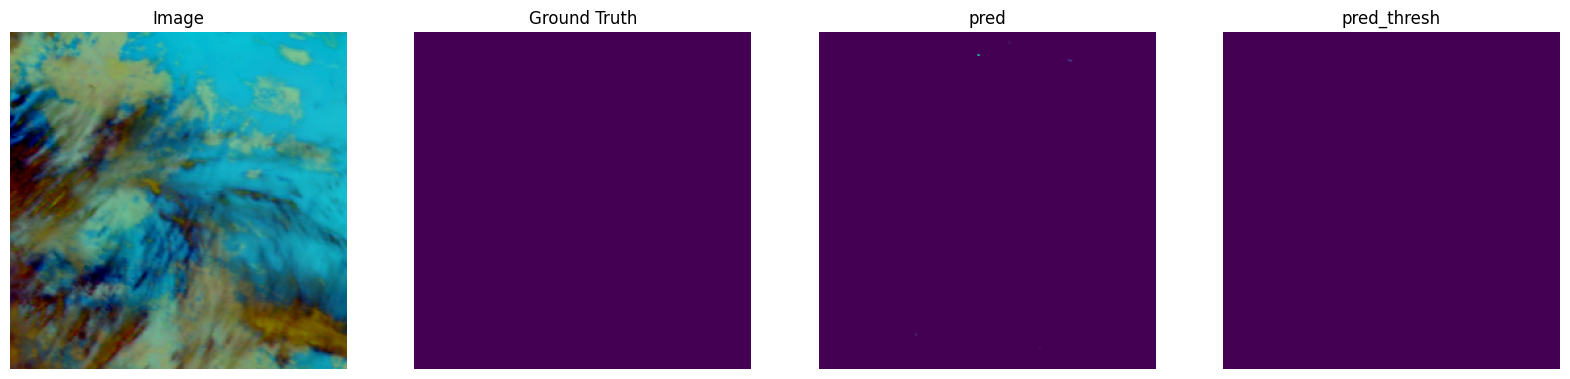

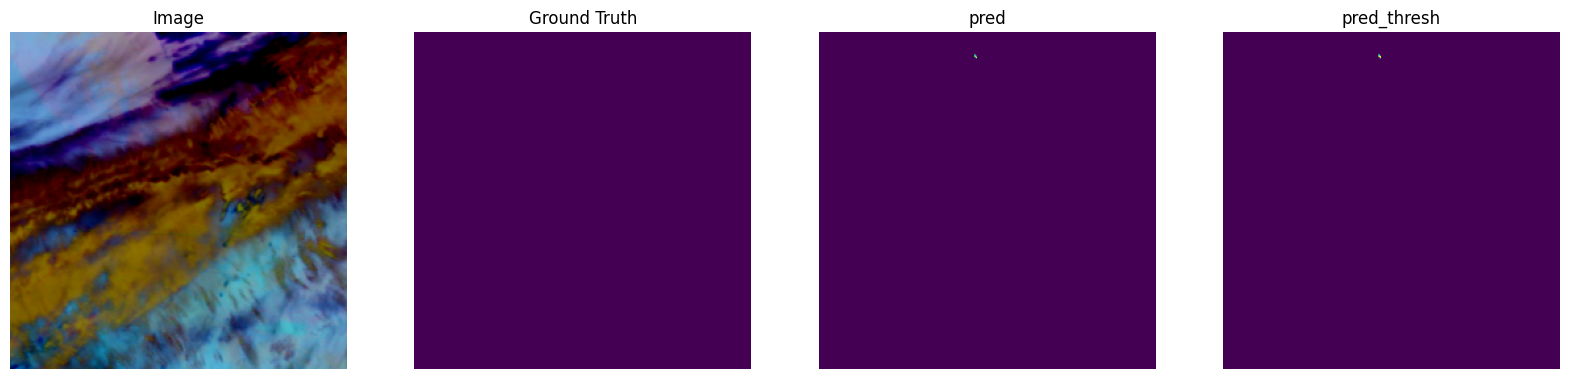

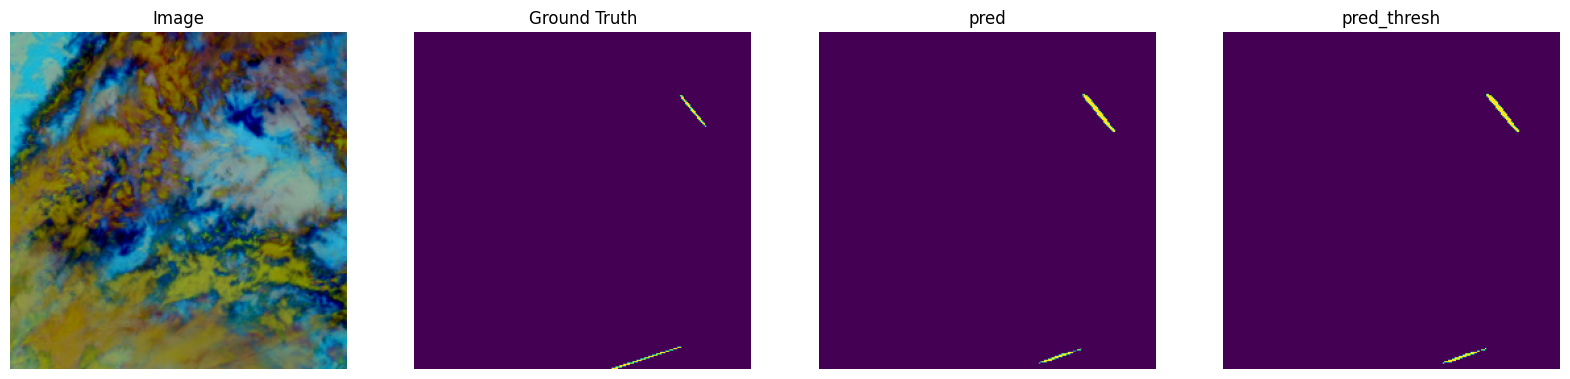

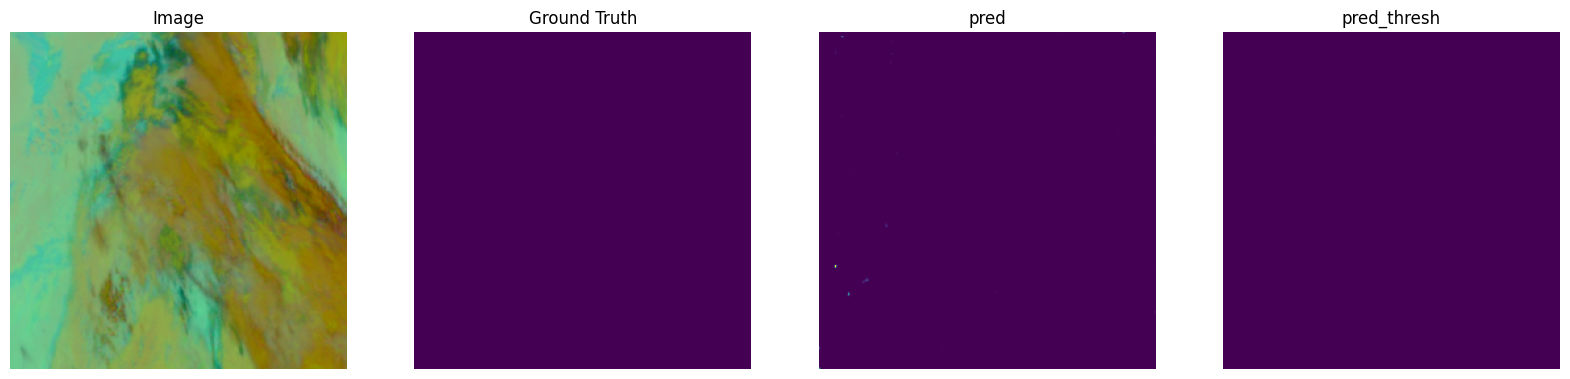

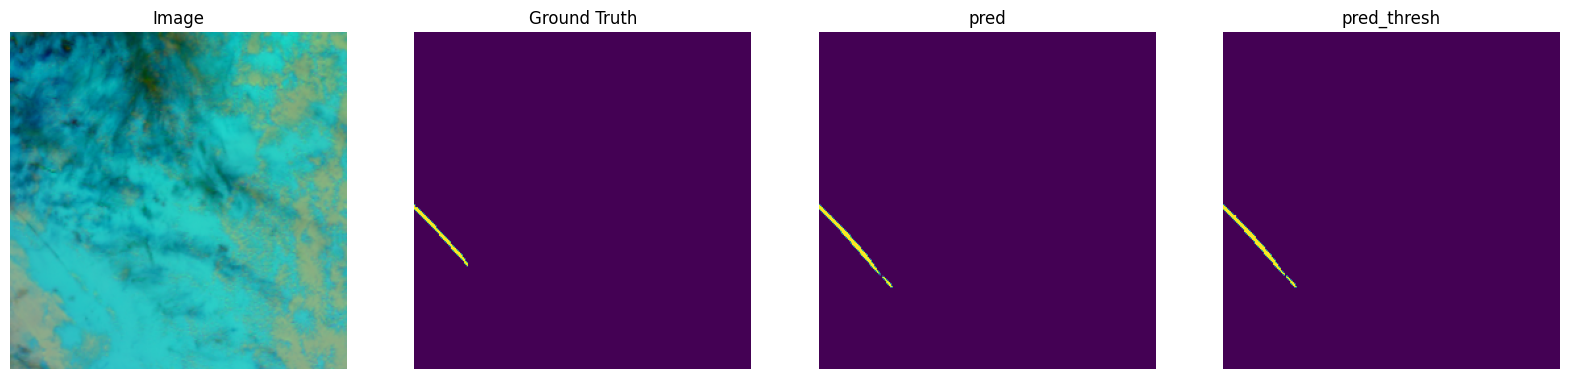

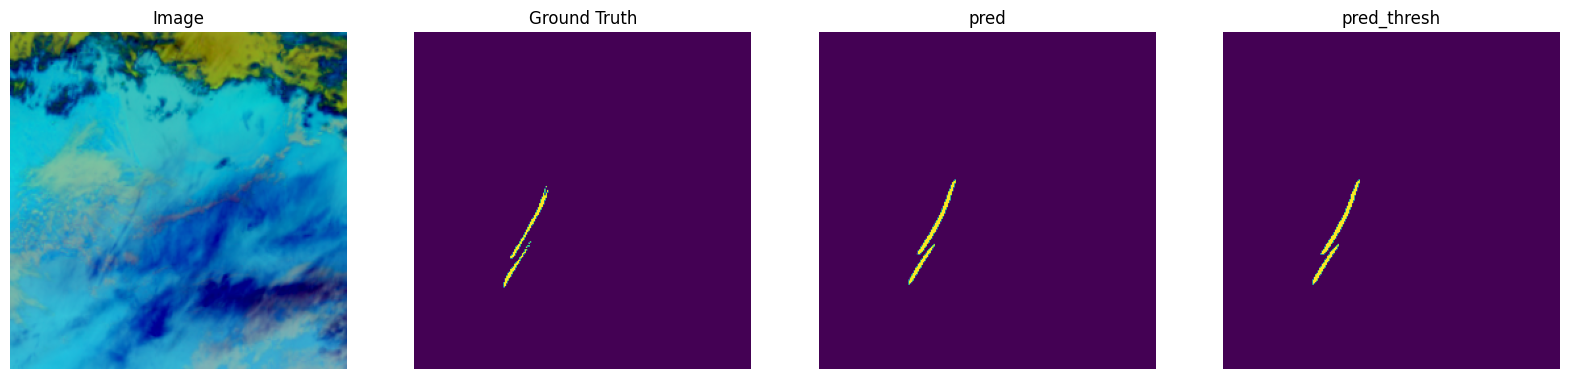

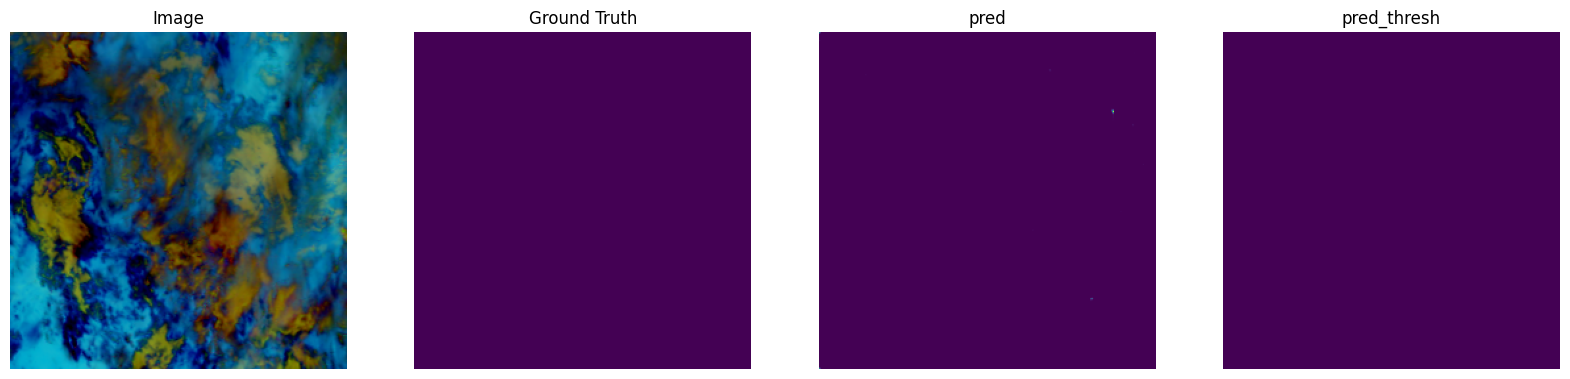

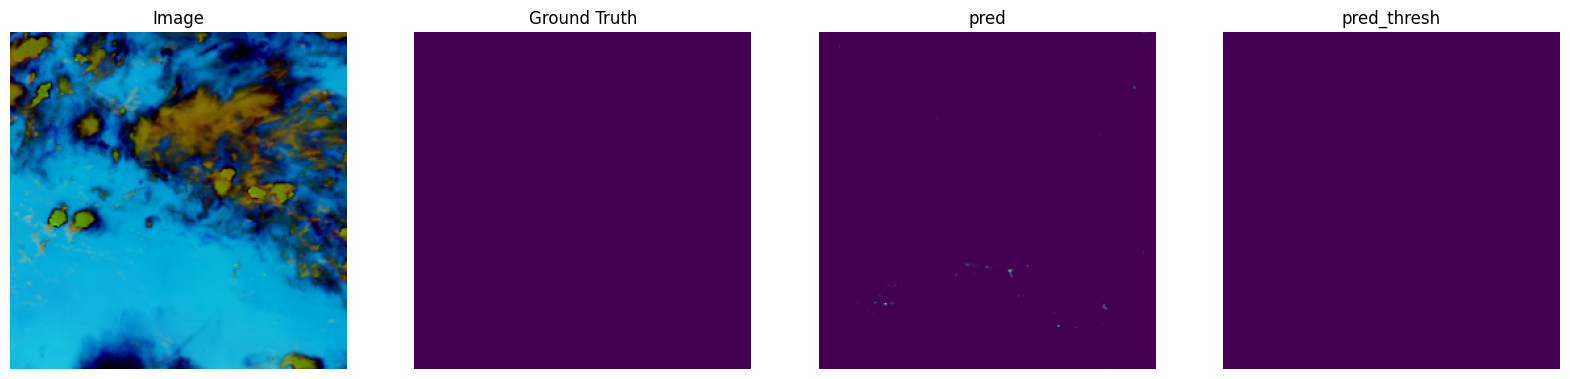

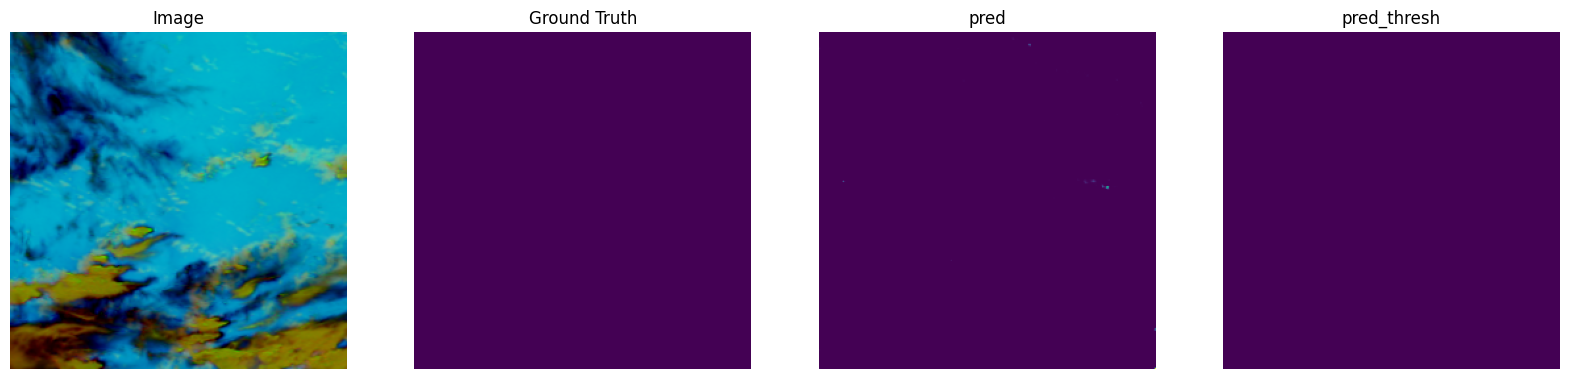

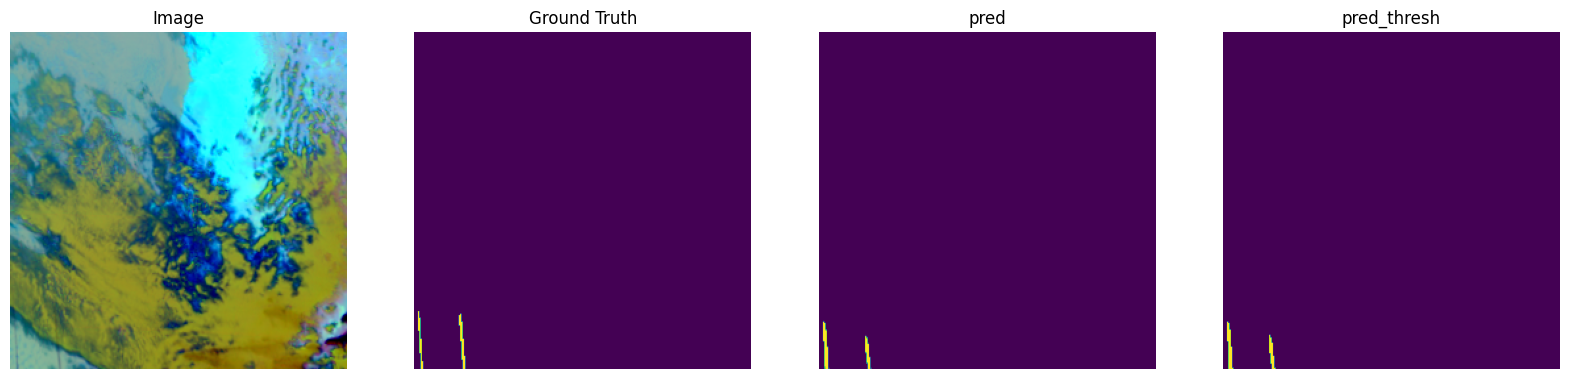

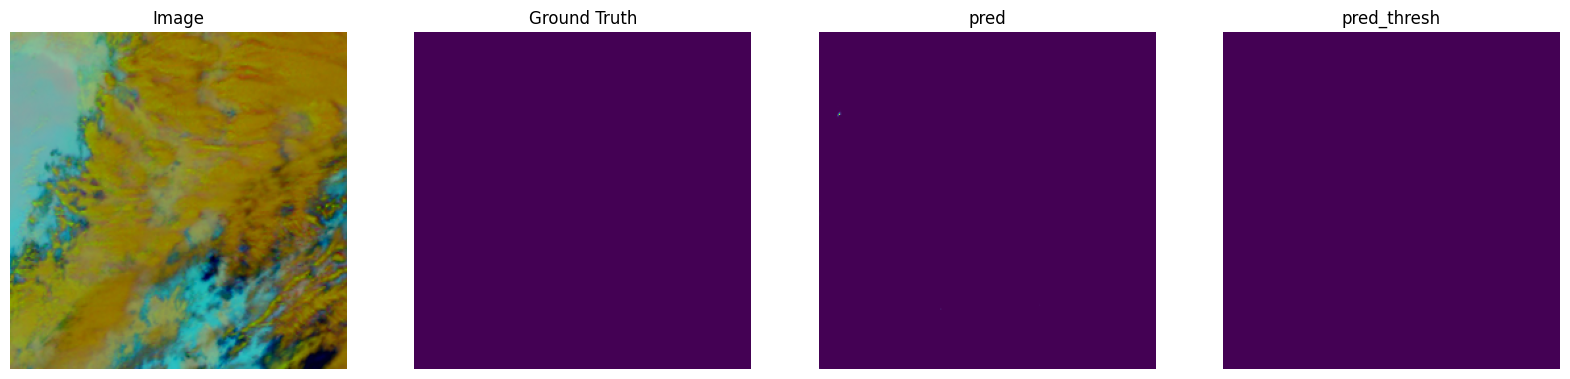

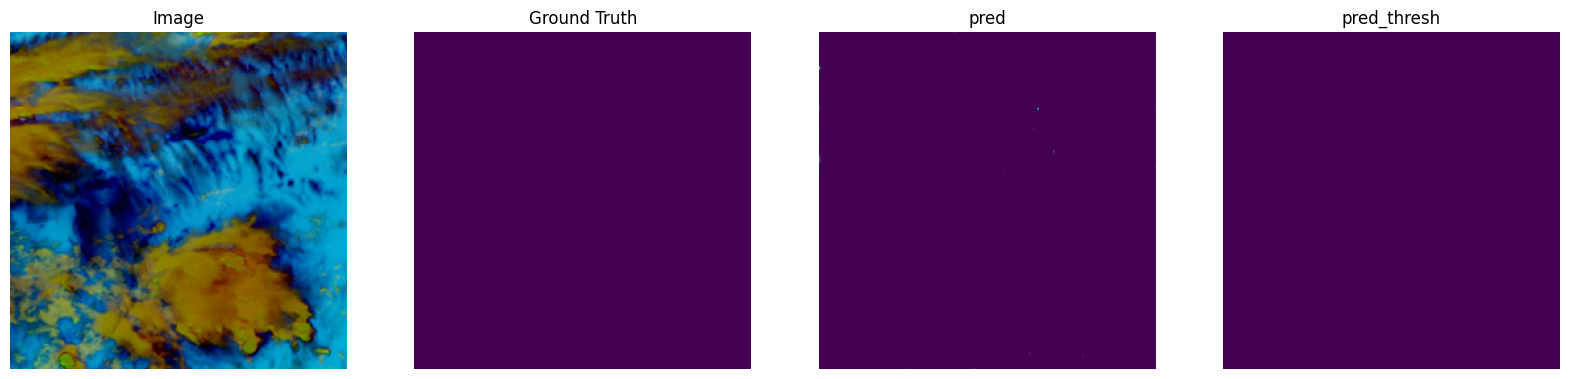

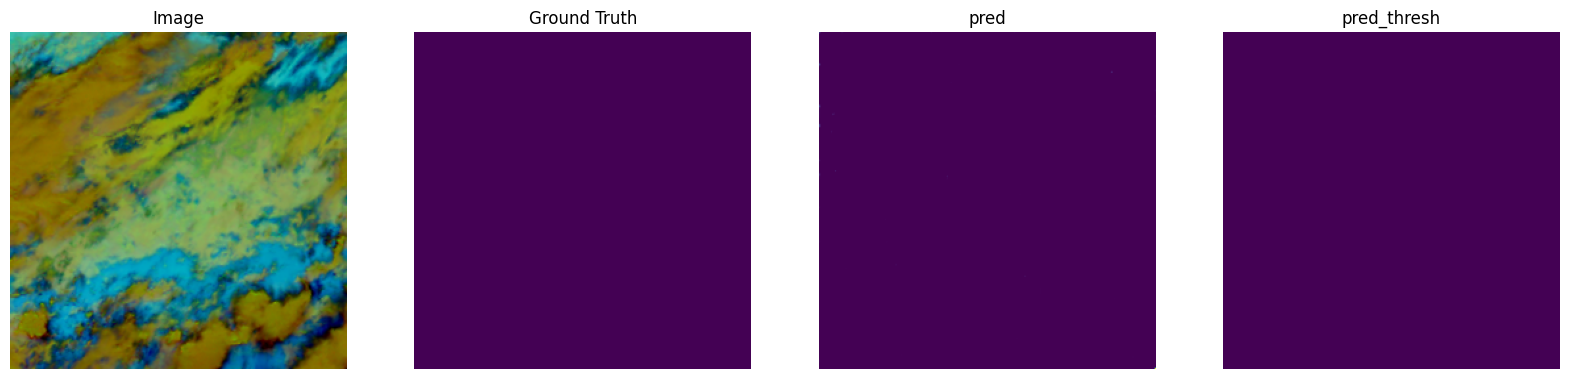

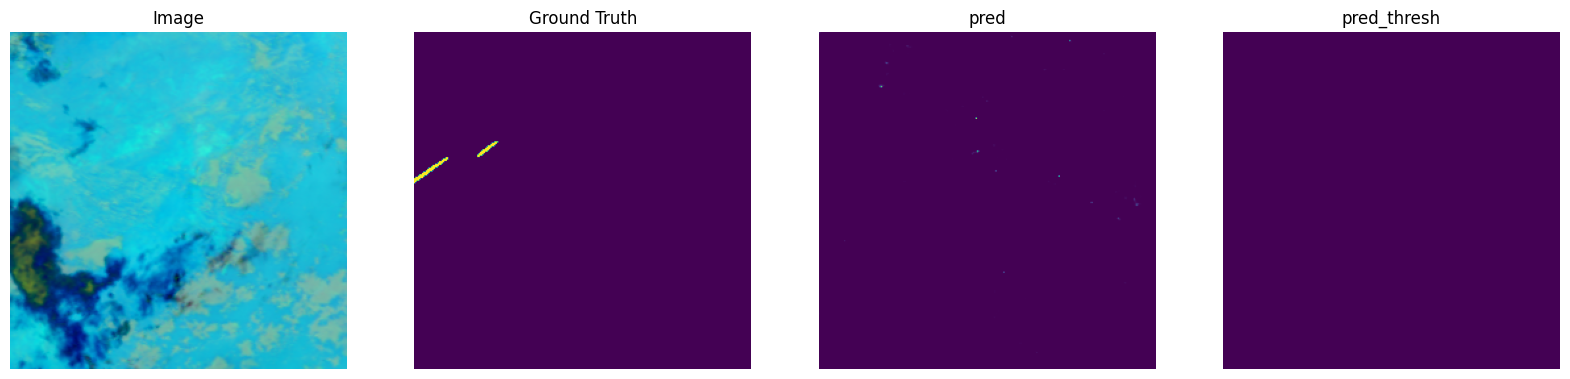

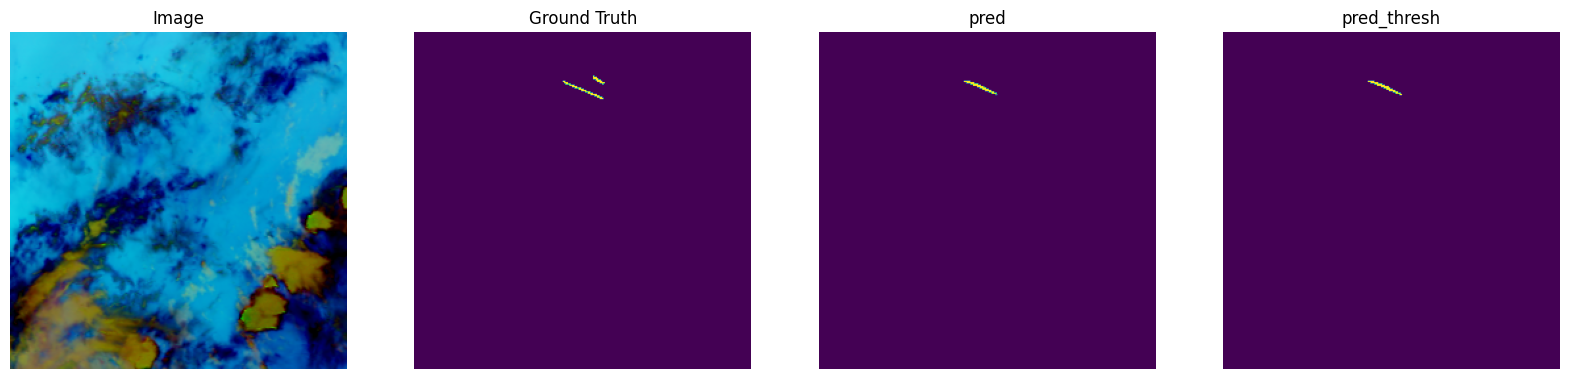

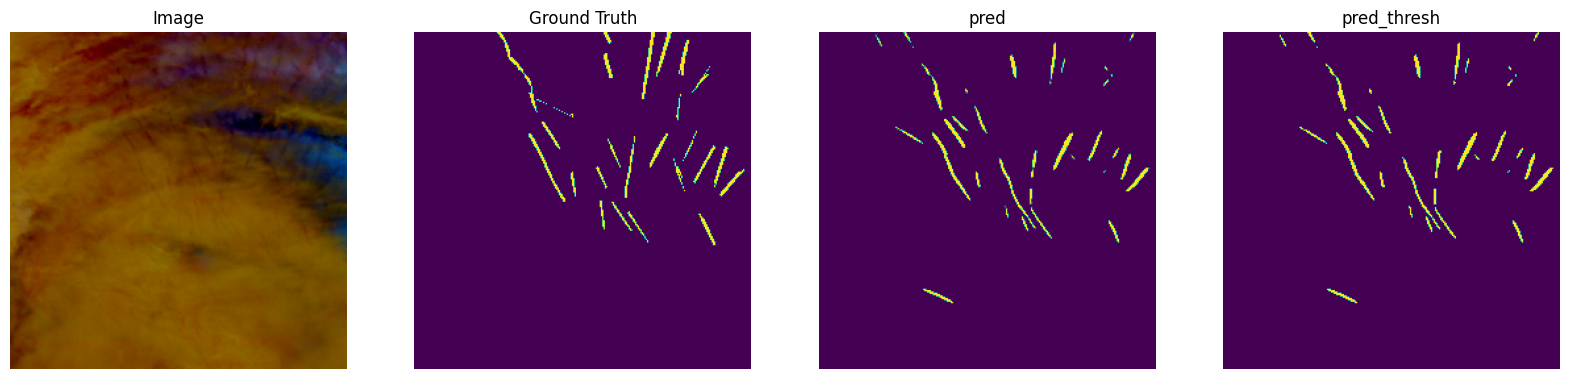

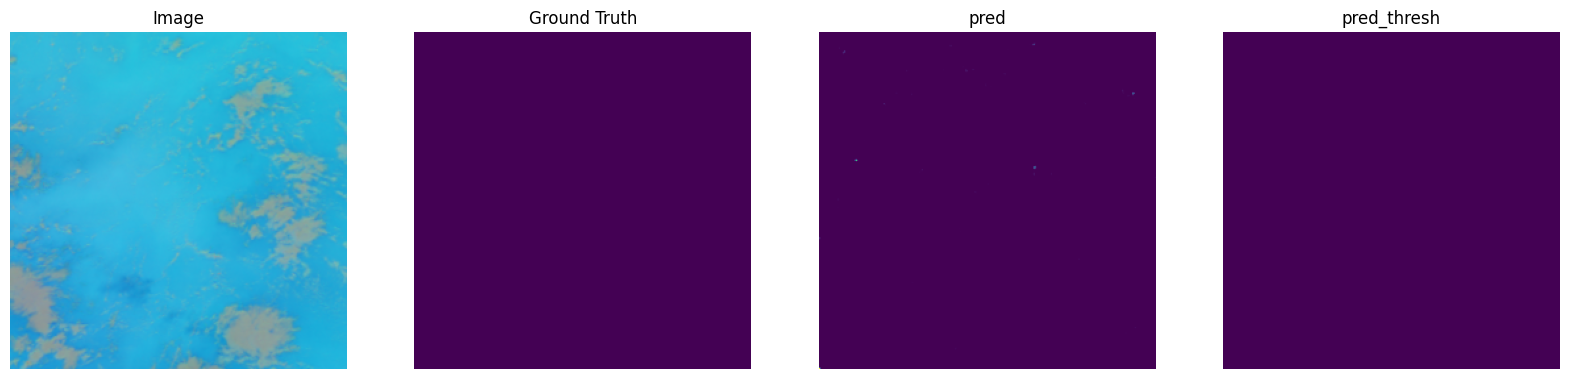

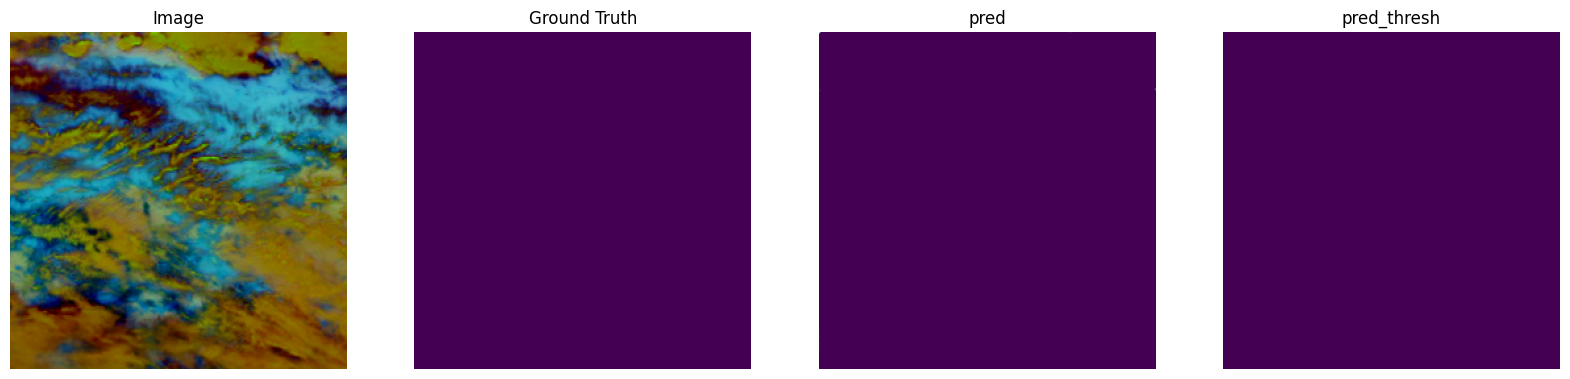

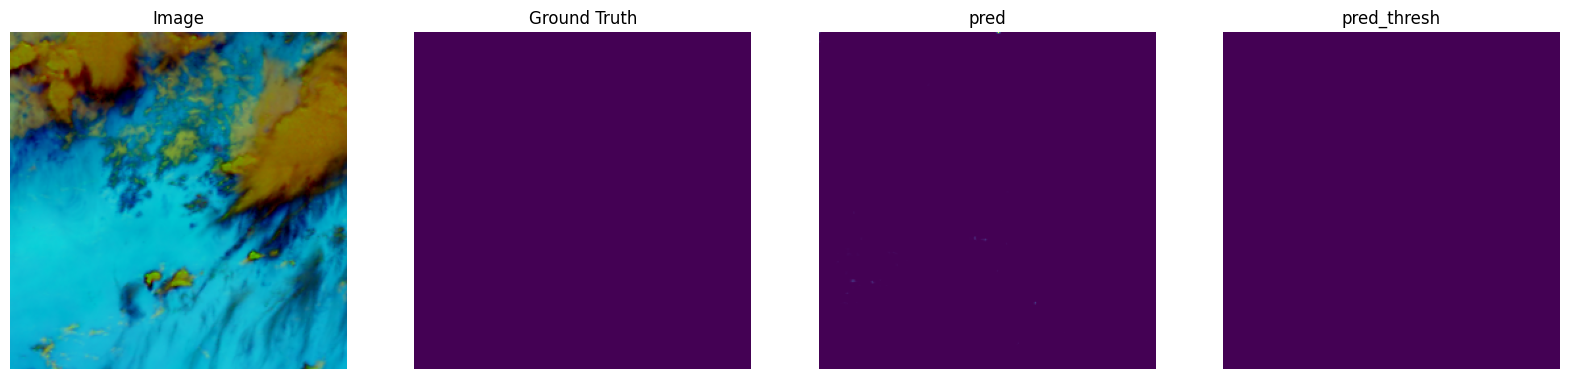

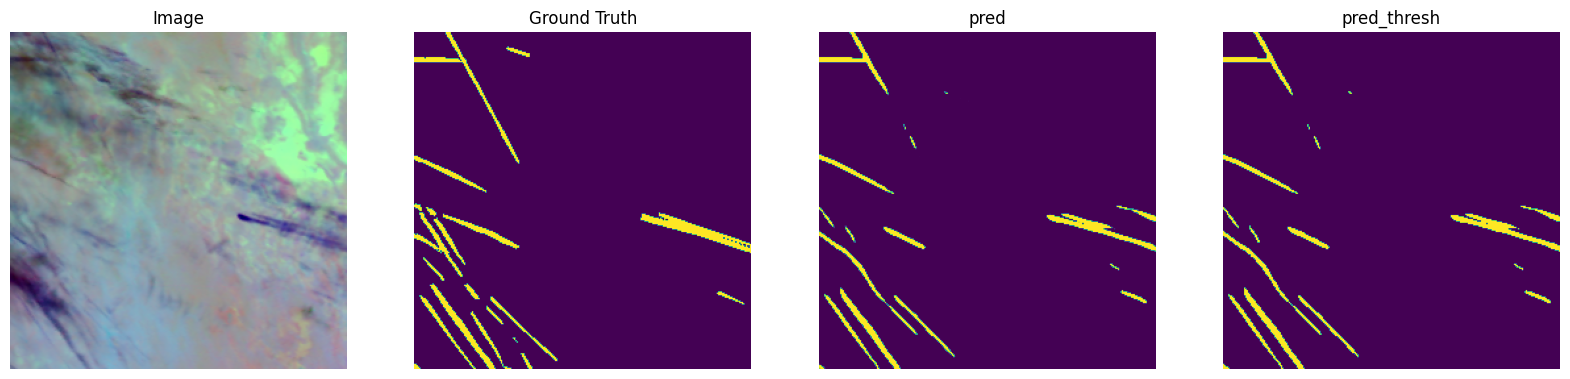

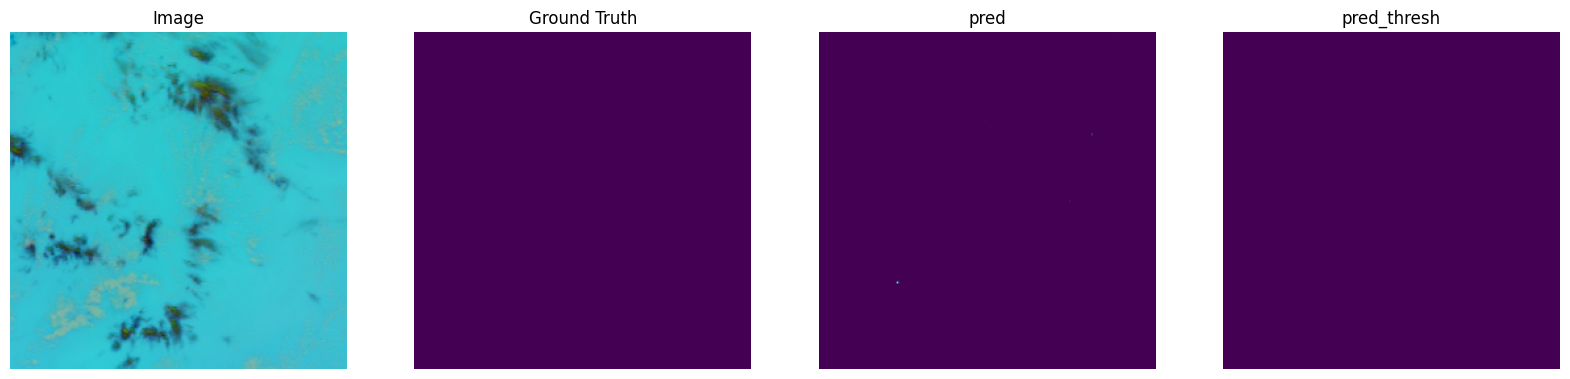

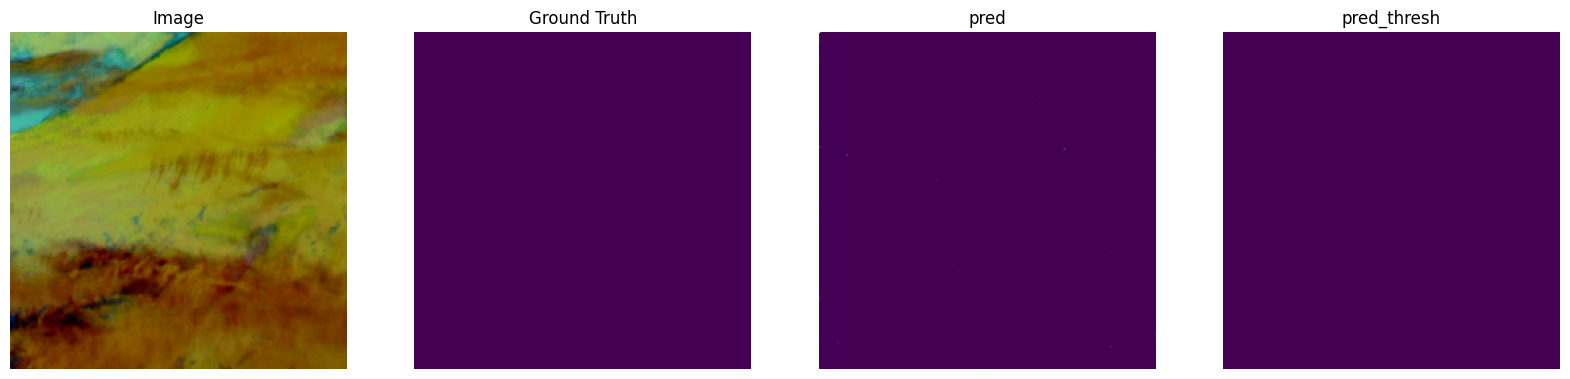

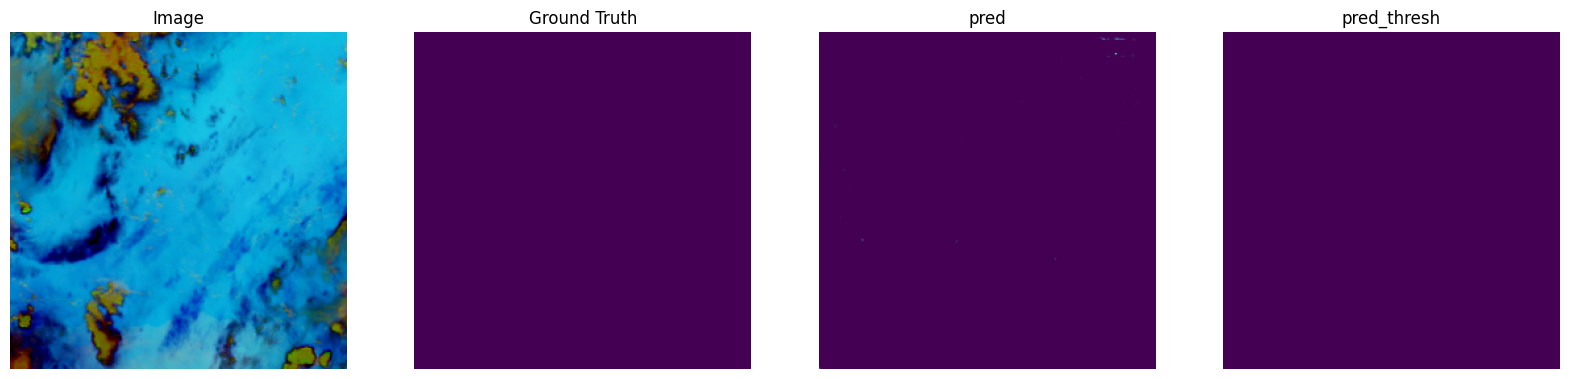

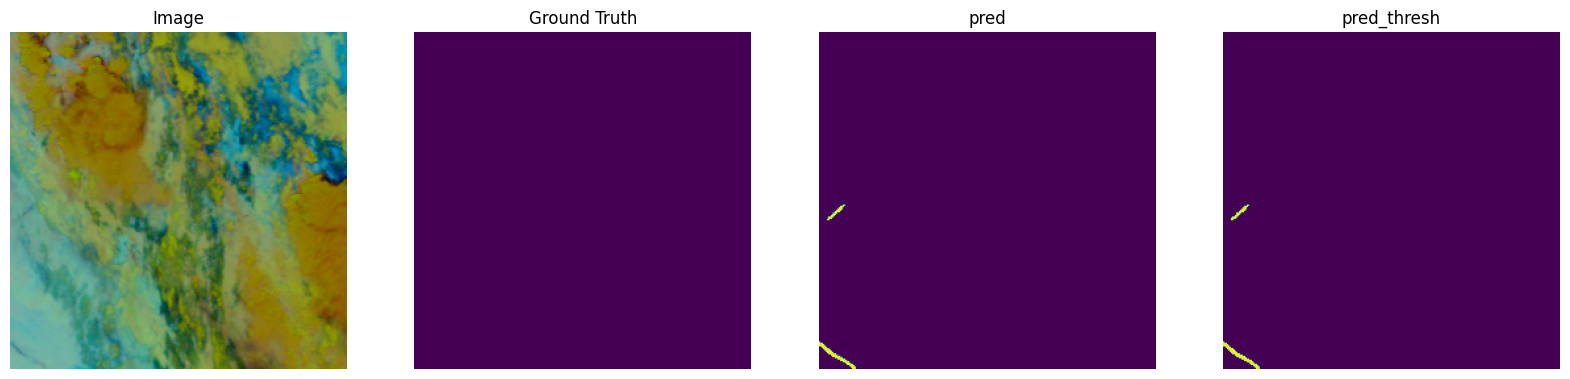

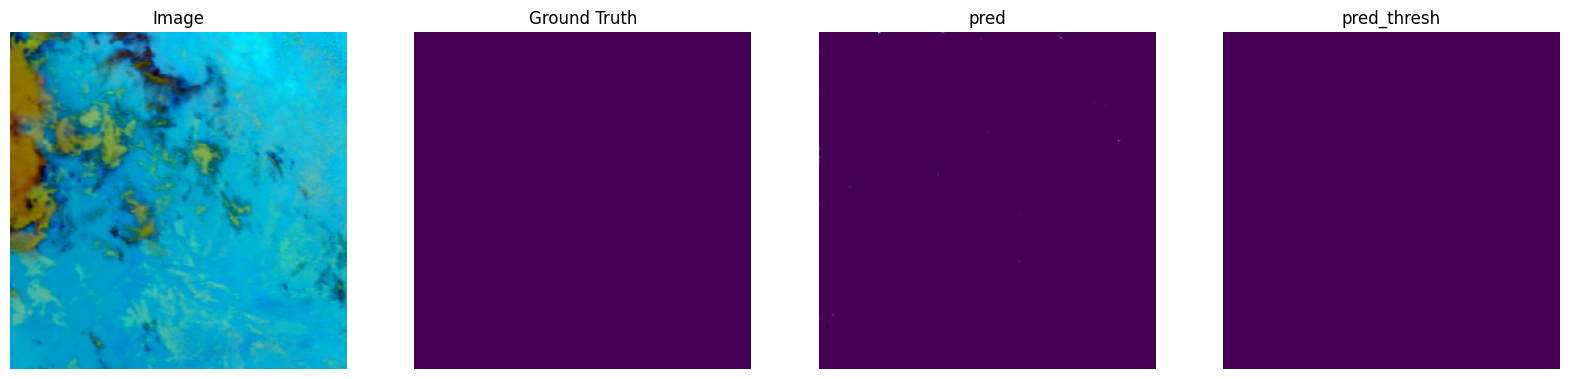

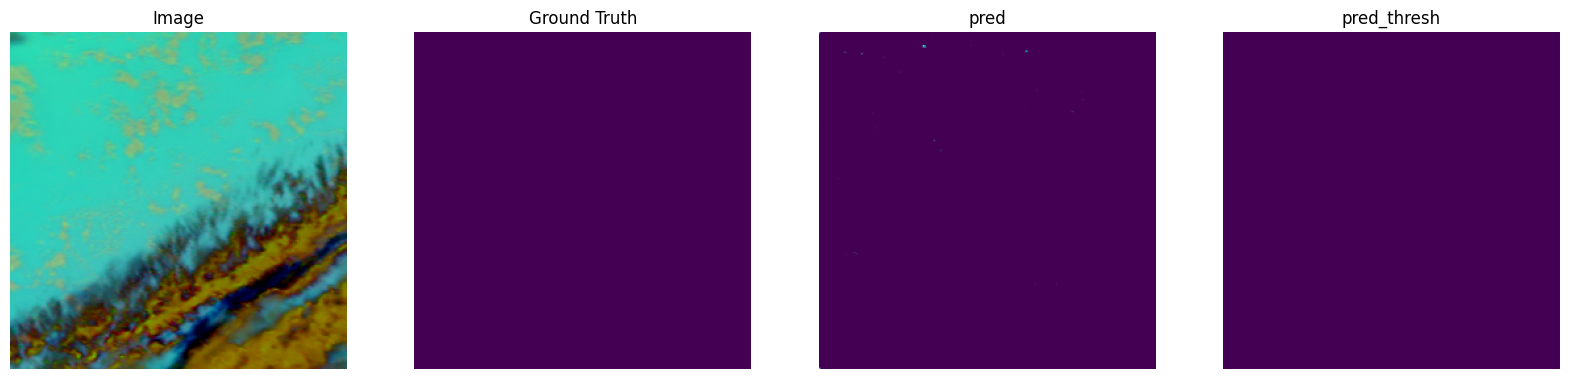

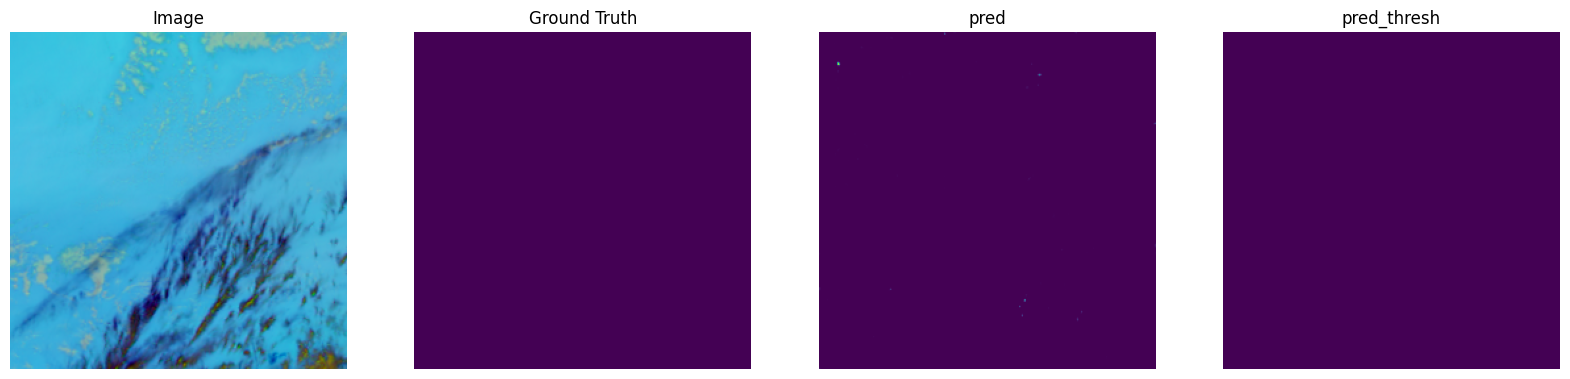

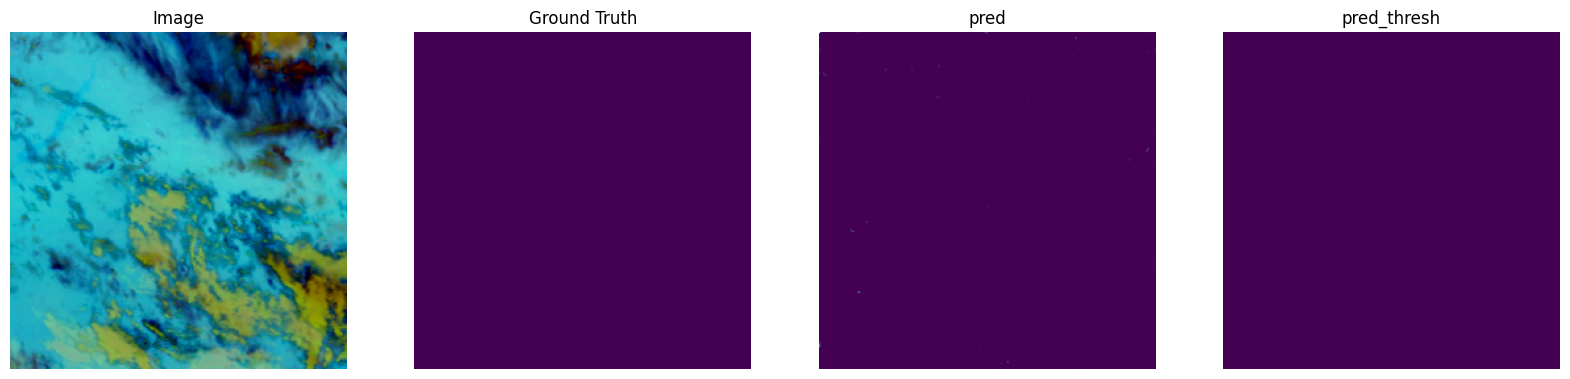

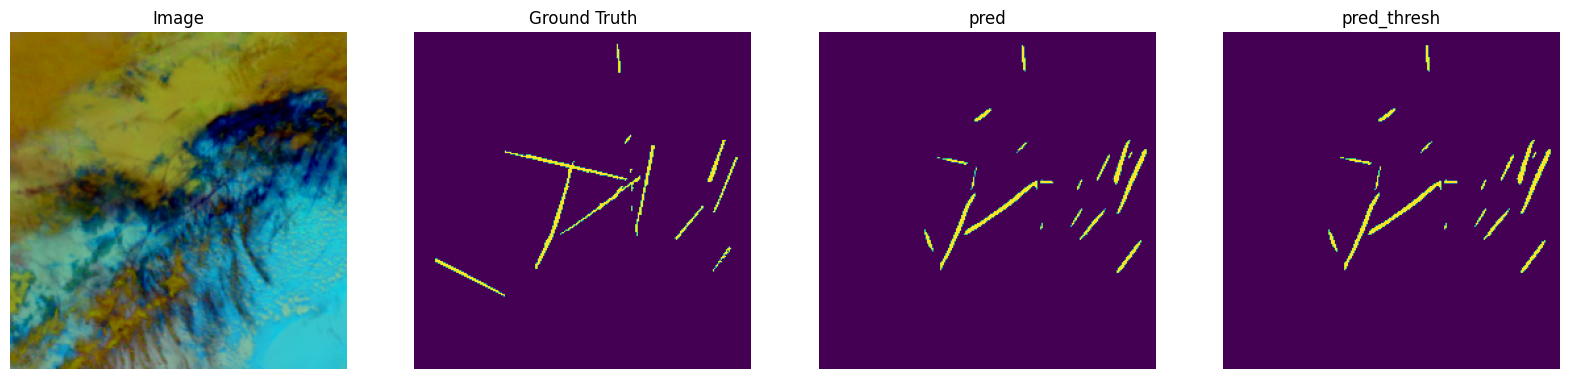

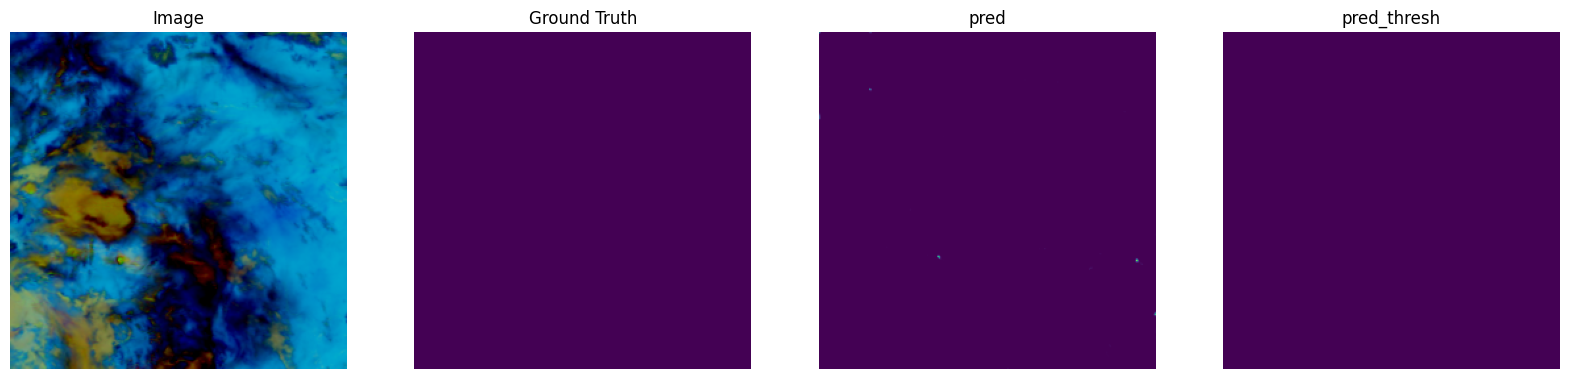

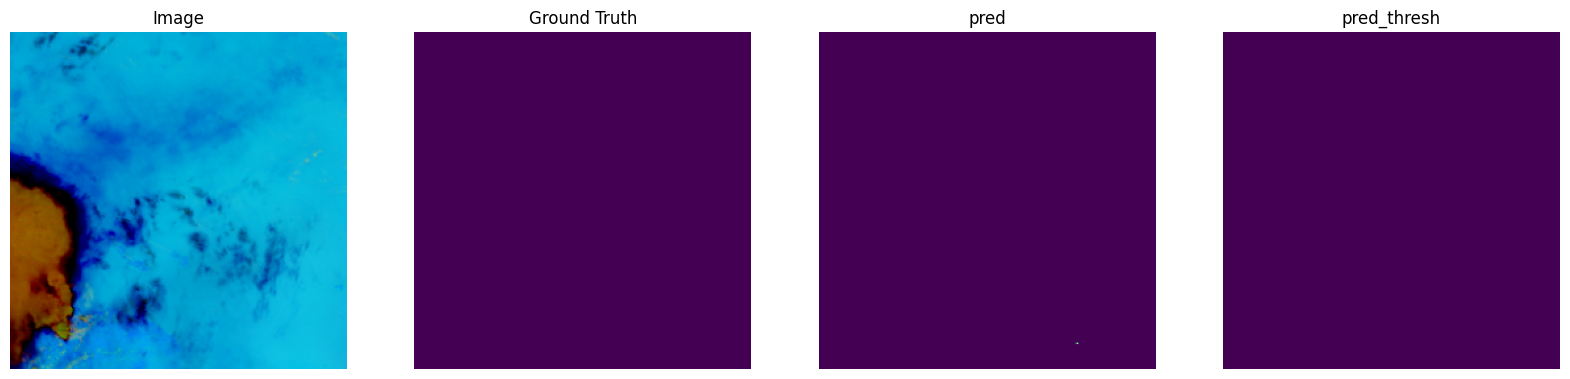

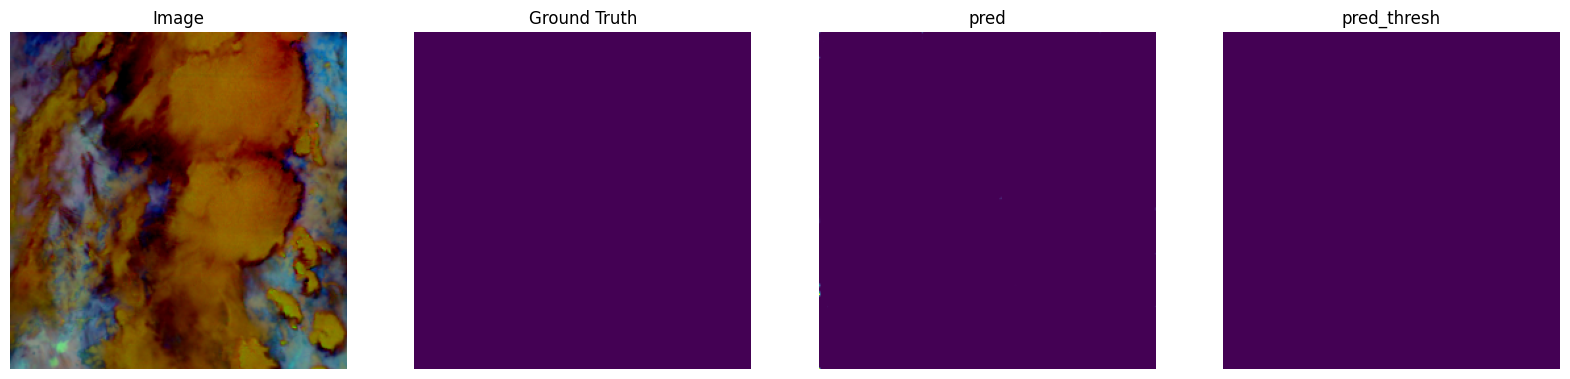

In [10]:
for i, (images, masks) in enumerate(dataloader_valid):
    if i!=1: continue
    
    images, masks = images.cuda(), masks.cuda()
    with torch.no_grad():
        preds = model(images)
        preds = torch.sigmoid(preds)
    images, masks, preds = images.cpu(), masks.cpu(), preds.cpu()
    
    for num in range(CFG.valid_batch_size):
        fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,5))
        axes = axes.flatten()
        axes[0].imshow(images[num].permute(1,2,0))
        axes[0].axis('off')
        axes[0].set_title('Image')
        axes[1].imshow(masks[num].permute(1,2,0))
        axes[1].axis('off')
        axes[1].set_title('Ground Truth')
        axes[2].imshow(preds[num].permute(1,2,0))
        axes[2].axis('off')
        axes[2].set_title('pred')
        axes[3].imshow((preds[num]>thresh).permute(1,2,0))
        axes[3].axis('off')
        axes[3].set_title('pred_thresh')
    break